In [1]:
# Standard libraries
from pathlib import Path
import datetime

# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from ml_model_training import train_xgboost
from kmeans_clustering import cluster_create_sub_dataframes
from plot_functions import plot_everything
from feature_selection import xgboost_feature_selection, random_forest_feature_importance, correlation_feature_selection




In [6]:
'''
These are the resource utilization datasets from the Titan supercompter at Oak Ridge National Laboratory for the years 2015-2019. Every file is associated with a header and each row corresponds to the total resource utilization statistics of a job that ran on Titan. The most important features are:
1. user_id: The used who submitted the job.
2. start_time: The timestamp when the job started.
3. end_time: The timestamp when the job ended.
4. stime, utime: The CPU time in Titan
5. alps_exit: status field - if a job runs successfully, only then job return status is zero
6. command: The executable of the job. The format is "/lustre/fileSystem/ProjectID-ProjectNumber/Application". For Titan, there were three different file system types under Lustre - atlas, atlas1 and atlas2. Jobs could select any one. 

Example: /lustre/atlas/User1027/Area8-7/acemd_2019.bin - The application 'acemd_2019.bin' belonged to project ID 'Area8' with the project Number '7'. User1027 submitted this job which ran on the 'atlas' file system in Lustre. 
Many commands do not have the file system or the user or the project information. 
Project ID is mapped to a domain science in the ProjectAreas.csv dataset. 

7. node_count: Number of nodes that the job ran.
8. max_rss: Estimate of the maximum resident CPU memory used by an individual compute node through the lifespan of a job run.
(Each Titan compute node is equipped with a 16-core CPU with a total of 32 GiB CPU memory, and every CPU is paired with a single GPU with a 6 GiB GPU memory.)
9. rchar, wchar: Bytes read and bytes written per process.
10. gpu_mode: Indicates how GPUs are used.  The GPU is in an exclusive mode, if only one process can operate a context to the GPU. An application can request the default mode, where multiple processes can communicate with a GPU.
11. gpu_secs: Time spent on GPUs by the job.
12. gpu_maxmem: Maximum GPU memory used by all the nodes.
13. gpu_summem: Total GPU memory used by all the nodes.
'''

use_col_headers = [
    "user_id", "start_time", "end_time", "stime", "utime", "alps_exit", 
    "alps_nppn", "alps_width", "alps_resid", "aprun_id", "command", 
    "node_count", "max_rss", "rchar", "wchar", "gpu_mode", "gpu_pids", 
    "gpu_secs", "gpu_maxsecs", "gpu_maxmem", "gpu_summem"
]

In [9]:
file_path = '/projectnb/peaclab-mon/boztop/resource-allocation/datasets/titan_rur_2019.csv'

df = pd.read_csv(file_path, skiprows=1, names=use_col_headers)

In [11]:
sorted_df = df.sort_values(by='end_time')

sorted_df

,user_id,start_time,end_time,stime,utime,alps_exit,alps_nppn,alps_width,alps_resid,aprun_id,...,node_count,max_rss,rchar,wchar,gpu_mode,gpu_pids,gpu_secs,gpu_maxsecs,gpu_maxmem,gpu_summem
551351,User2258,2019-01-01 04:59:50.049831,2019-01-01 05:00:00.568477,5.997000e+08,5.655240e+08,0,0.0,256.0,1919419,19493557,...,16,1064412.0,3.594688e+07,1.471420e+07,exclusive_process,0.0,0.0,0.0,0.0,0.000000e+00
551352,User2258,2019-01-01 04:59:53.869254,2019-01-01 05:00:10.285502,5.282080e+08,2.217440e+08,0,0.0,128.0,1919420,19493558,...,8,1061728.0,2.165468e+07,2.822011e+07,exclusive_process,0.0,0.0,0.0,0.0,0.000000e+00
551353,User2258,2019-01-01 05:00:03.017919,2019-01-01 05:00:11.185420,5.961360e+08,6.111680e+08,0,0.0,256.0,1919419,19493559,...,16,1065944.0,6.359030e+07,1.160132e+08,exclusive_process,0.0,0.0,0.0,0.0,0.000000e+00
551354,User2258,2019-01-01 05:00:13.577867,2019-01-01 05:00:24.193063,5.973280e+08,5.943400e+08,0,0.0,256.0,1919419,19493561,...,16,1064424.0,3.594689e+07,1.463475e+07,exclusive_process,0.0,0.0,0.0,0.0,0.000000e+00
551355,User2258,2019-01-01 05:00:12.746582,2019-01-01 05:00:34.235133,5.696240e+08,6.781800e+08,0,0.0,128.0,1919420,19493560,...,8,1062860.0,2.030311e+07,2.844758e+08,exclusive_process,0.0,0.0,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608384,User1933,2019-07-13 07:25:02.985744,2019-07-13 10:20:04.940022,9.233780e+10,1.036699e+13,137,1.0,1000.0,2331944,21387932,...,1000,29812780.0,2.857472e+10,4.742946e+08,exclusive_process,1.0,8100545.0,8100545.0,0.0,0.000000e+00
608385,User1298,2019-07-13 07:26:45.840842,2019-07-13 10:27:34.458205,1.740700e+11,2.147242e+12,0,0.0,1.0,2331945,21387937,...,250,400756.0,8.515154e+09,3.216375e+10,exclusive_process,2.0,1336510.0,668291.0,878051328.0,1.288472e+11
608386,User1298,2019-07-13 07:27:01.233138,2019-07-13 17:35:59.993453,5.008943e+11,6.733338e+12,0,0.0,1.0,2331945,21387938,...,250,400484.0,7.560388e+09,9.280655e+10,exclusive_process,2.0,2563472.0,1281724.0,878051328.0,1.249242e+11
608387,User2278,2019-07-13 07:24:26.104459,2019-07-13 18:39:21.069442,8.426917e+11,9.560445e+14,137,0.0,24000.0,2331946,21387917,...,1500,3334188.0,6.021063e+12,2.780410e+11,exclusive_process,0.0,0.0,0.0,0.0,0.000000e+00


In [12]:

df_success = sorted_df[sorted_df['alps_exit'] == 0]
df_success = df_success.dropna()



In [13]:
# --- LET'S MAKE SOME OBSERVATIONS! ---
print(f"Total number of jobs in the dataset: {df_success.shape[0]}")

print(f"Number of unique users: {df_success['user_id'].nunique()}")
      
print("Categorization of jobs (gpu mode):")  
print(df_success['gpu_mode'].value_counts())




Total number of jobs in the dataset: 1415928
Number of unique users: 413
Categorization of jobs (gpu mode):
exclusive_process    1413938
default                 1990
Name: gpu_mode, dtype: int64


# Feature Importance for Training

In [14]:
df_success.columns

Index(['user_id', 'start_time', 'end_time', 'stime', 'utime', 'alps_exit',
       'alps_nppn', 'alps_width', 'alps_resid', 'aprun_id', 'command',
       'node_count', 'max_rss', 'rchar', 'wchar', 'gpu_mode', 'gpu_pids',
       'gpu_secs', 'gpu_maxsecs', 'gpu_maxmem', 'gpu_summem'],
      dtype='object')

In [15]:
categorical_submission_features = ['user_id', 'command', 'gpu_mode']
label_encoders = {col: LabelEncoder() for col in categorical_submission_features}

for col in categorical_submission_features:
    df_success[col] = label_encoders[col].fit_transform(df_success[col])

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Processing cluster 1/20
Train size (X_train): 13699
Test size (X_test): 3425
Train size (y_train): 13699
Test size (y_test): 3425


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


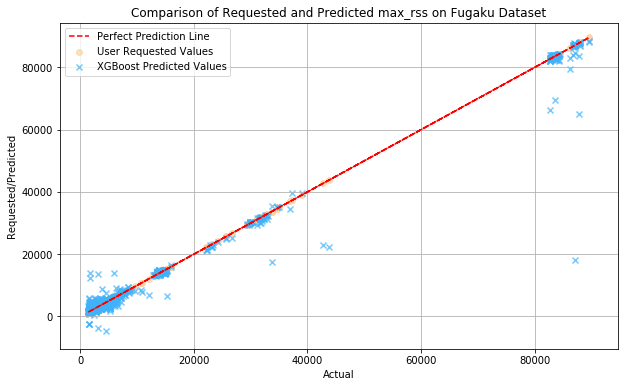

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


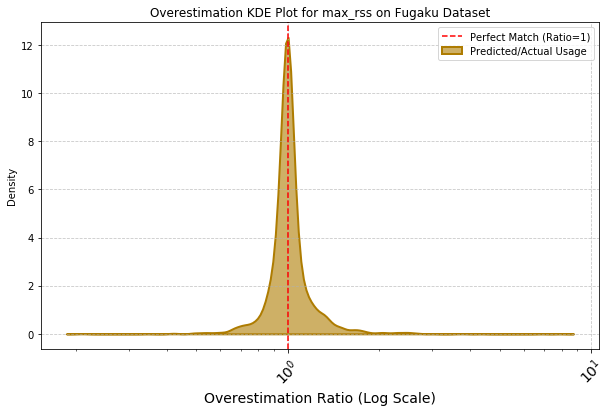

Processing cluster 2/20
Train size (X_train): 67924
Test size (X_test): 16981
Train size (y_train): 67924
Test size (y_test): 16981


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


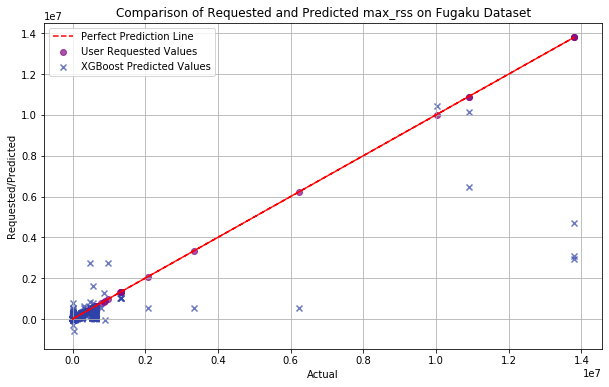

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


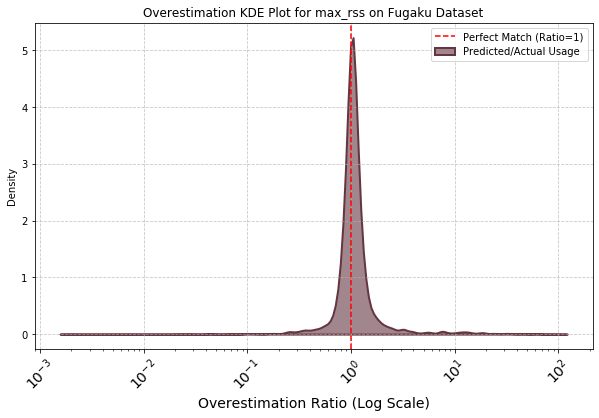

Processing cluster 3/20
Train size (X_train): 102632
Test size (X_test): 25659
Train size (y_train): 102632
Test size (y_test): 25659


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


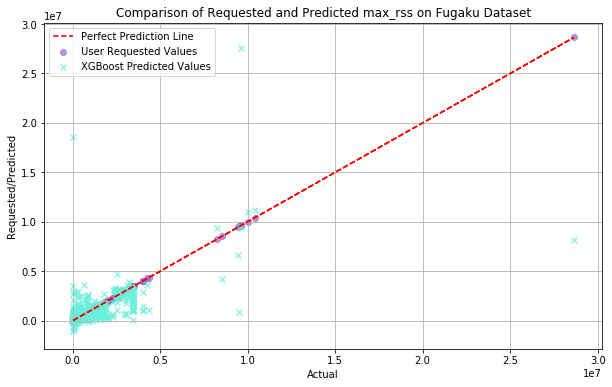

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


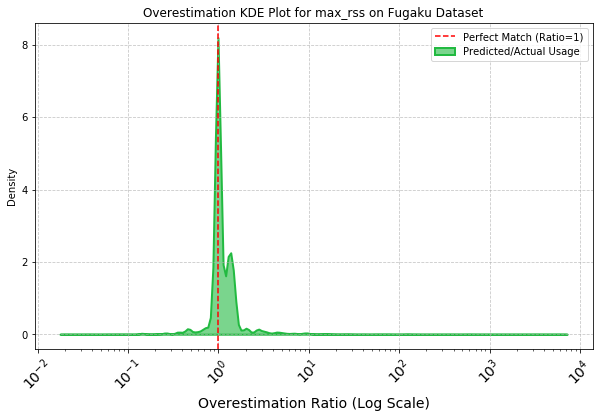

Processing cluster 4/20
Train size (X_train): 122538
Test size (X_test): 30635
Train size (y_train): 122538
Test size (y_test): 30635


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


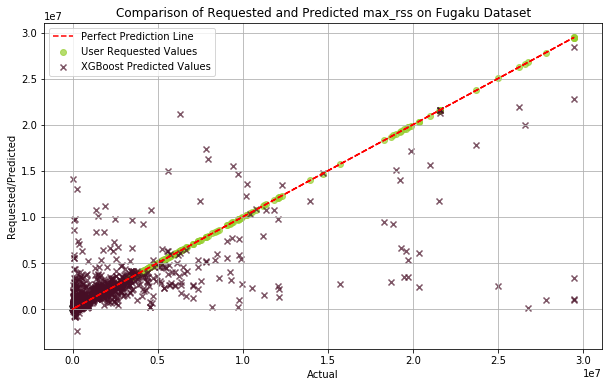

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


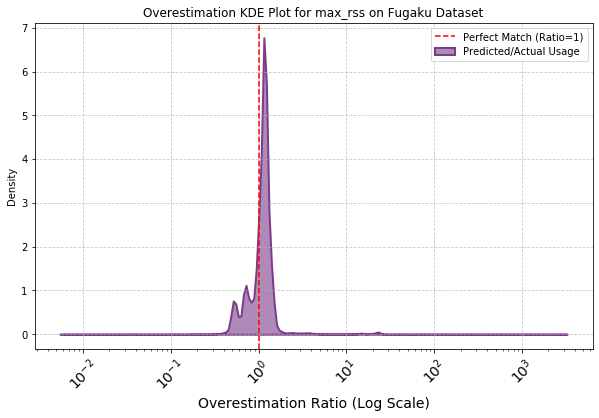

Processing cluster 5/20
Train size (X_train): 85566
Test size (X_test): 21392
Train size (y_train): 85566
Test size (y_test): 21392


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


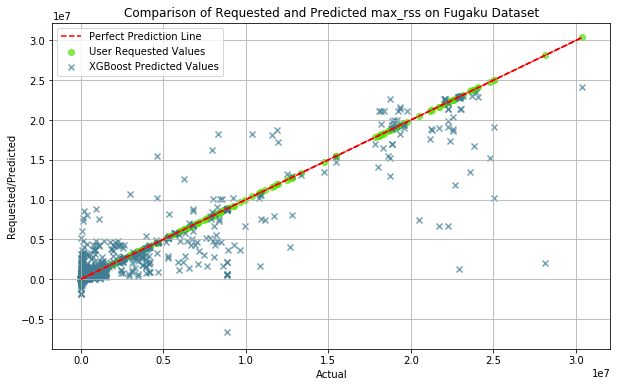

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


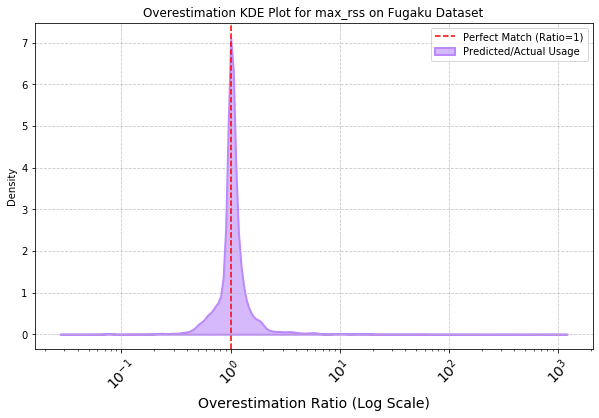

Processing cluster 6/20
Train size (X_train): 217932
Test size (X_test): 54484
Train size (y_train): 217932
Test size (y_test): 54484


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


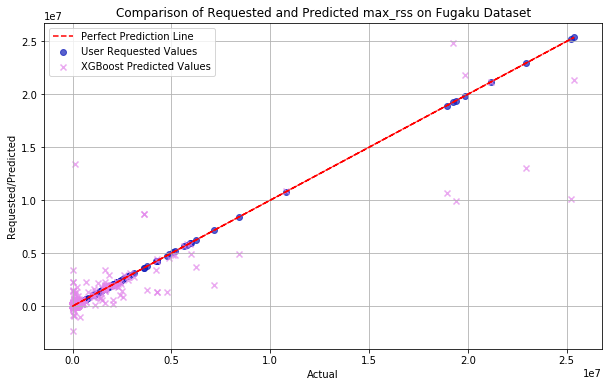

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


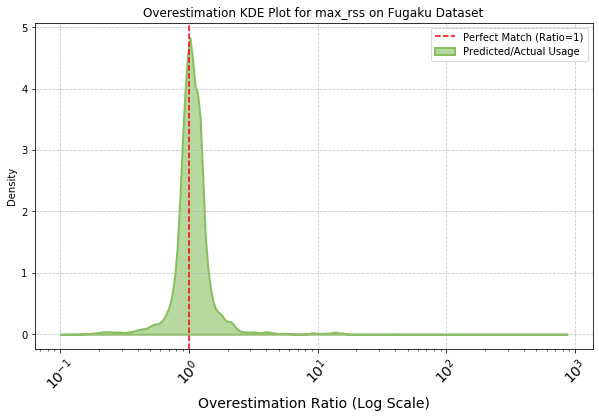

Processing cluster 7/20
Train size (X_train): 85218
Test size (X_test): 21305
Train size (y_train): 85218
Test size (y_test): 21305


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


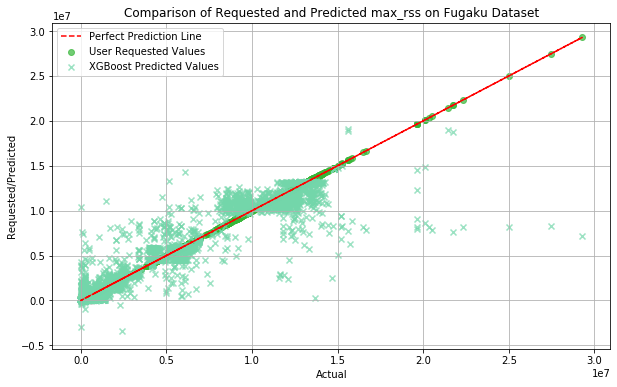

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


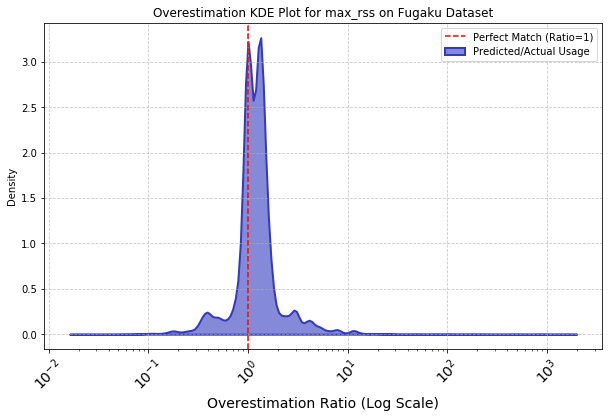

Processing cluster 8/20
Train size (X_train): 19043
Test size (X_test): 4761
Train size (y_train): 19043
Test size (y_test): 4761


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


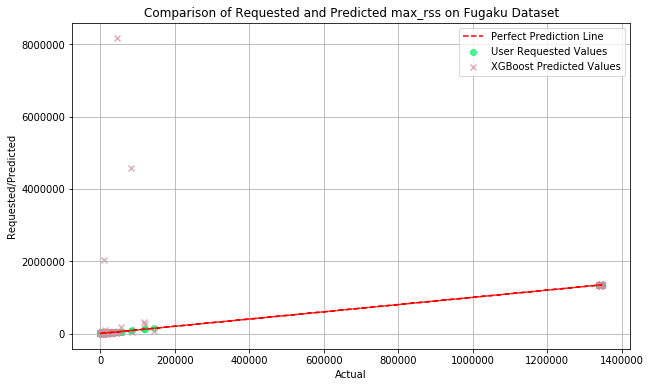

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


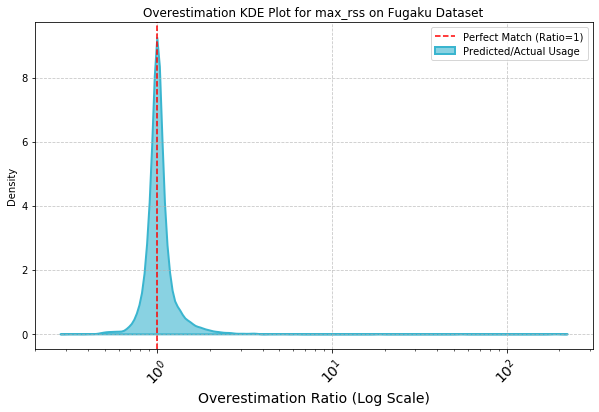

Processing cluster 9/20
Train size (X_train): 61983
Test size (X_test): 15496
Train size (y_train): 61983
Test size (y_test): 15496


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


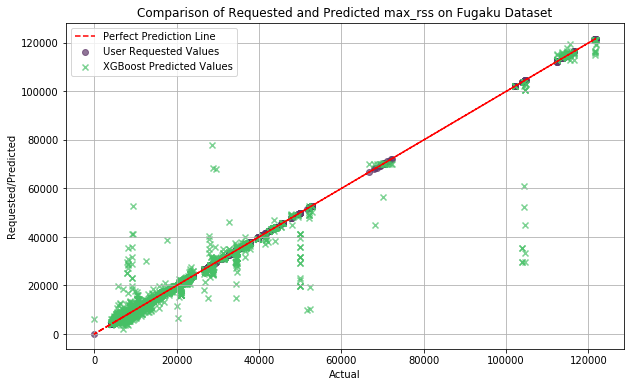

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


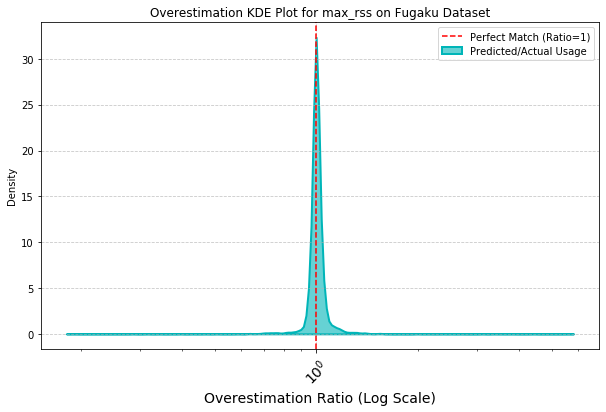

Processing cluster 10/20
Train size (X_train): 24262
Test size (X_test): 6066
Train size (y_train): 24262
Test size (y_test): 6066


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


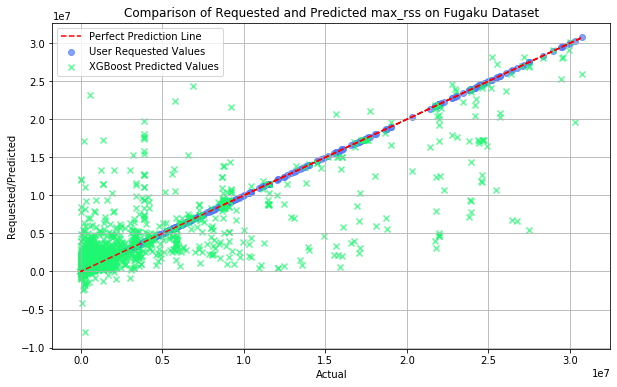

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


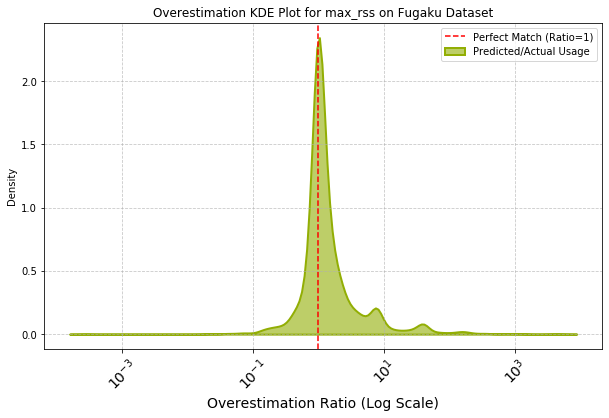

Processing cluster 11/20
Train size (X_train): 35616
Test size (X_test): 8904
Train size (y_train): 35616
Test size (y_test): 8904


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


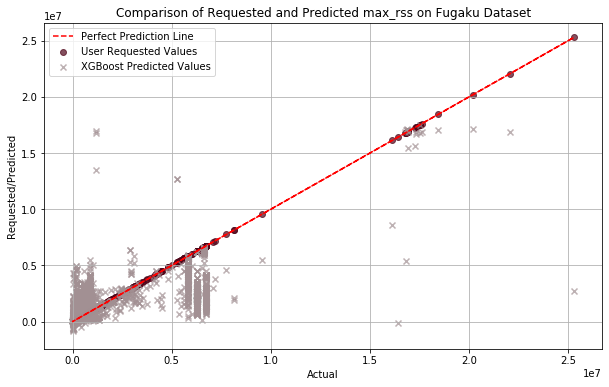

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


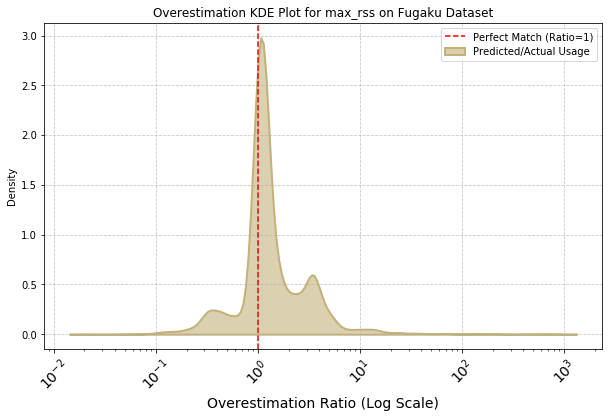

Processing cluster 12/20
Train size (X_train): 11444
Test size (X_test): 2862
Train size (y_train): 11444
Test size (y_test): 2862


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


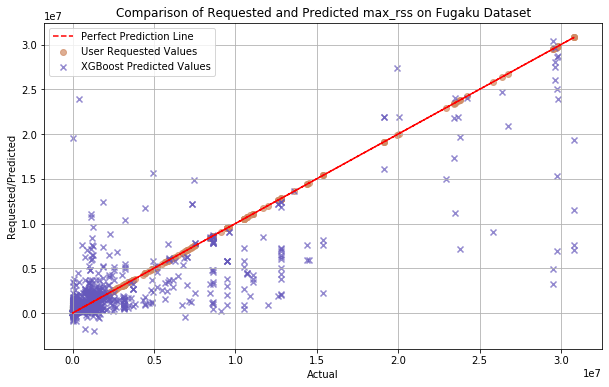

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


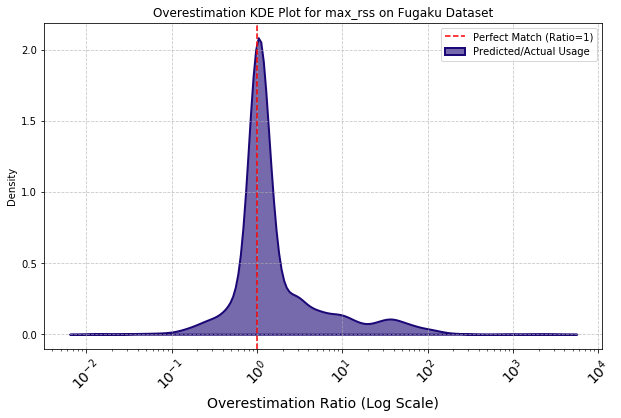

Processing cluster 13/20
Train size (X_train): 93888
Test size (X_test): 23472
Train size (y_train): 93888
Test size (y_test): 23472


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


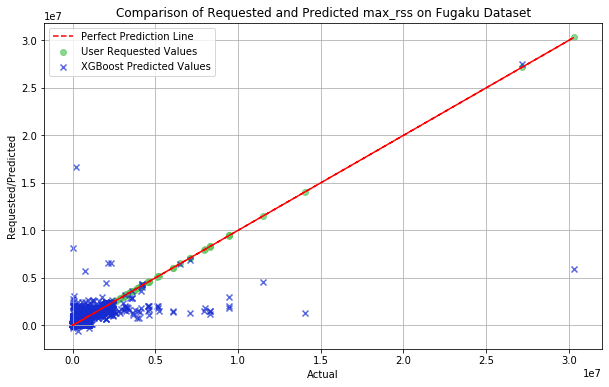

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


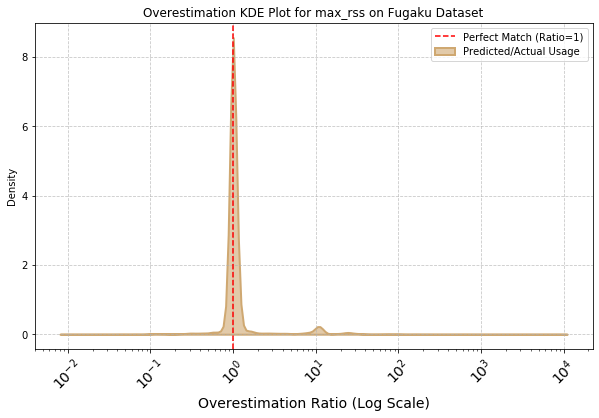

Processing cluster 14/20
Train size (X_train): 39101
Test size (X_test): 9776
Train size (y_train): 39101
Test size (y_test): 9776


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


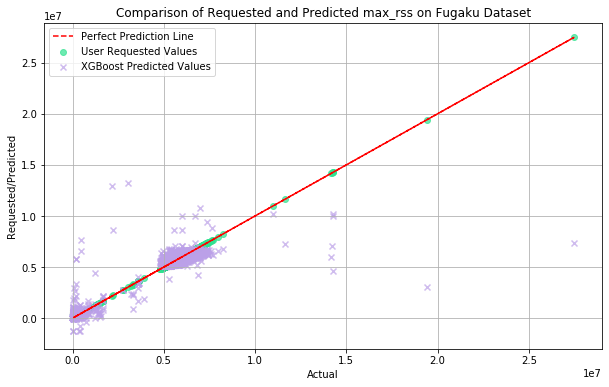

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


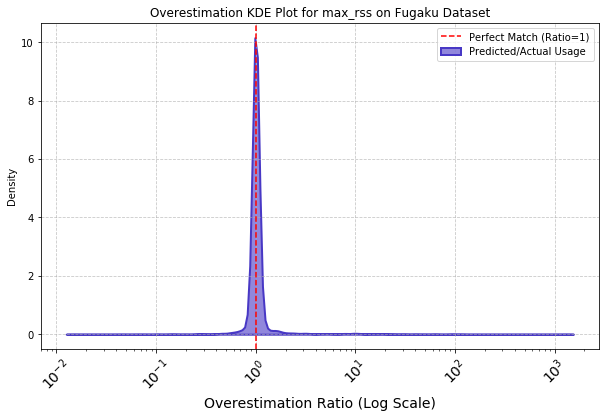

Processing cluster 15/20
Train size (X_train): 19700
Test size (X_test): 4926
Train size (y_train): 19700
Test size (y_test): 4926


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


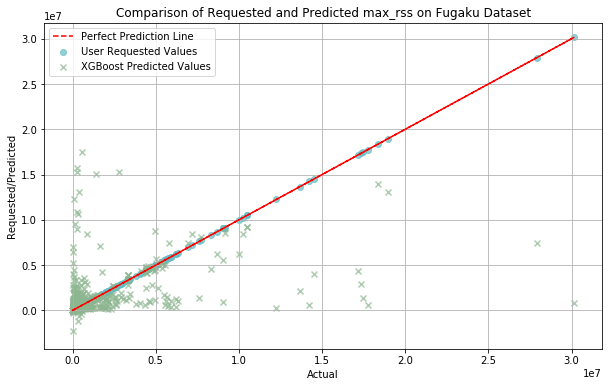

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


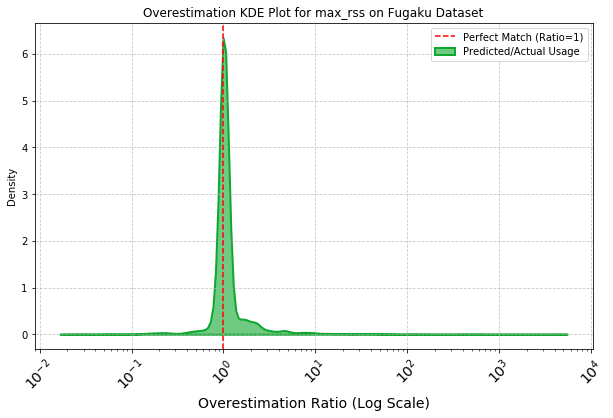

Processing cluster 16/20
Train size (X_train): 10556
Test size (X_test): 2640
Train size (y_train): 10556
Test size (y_test): 2640


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


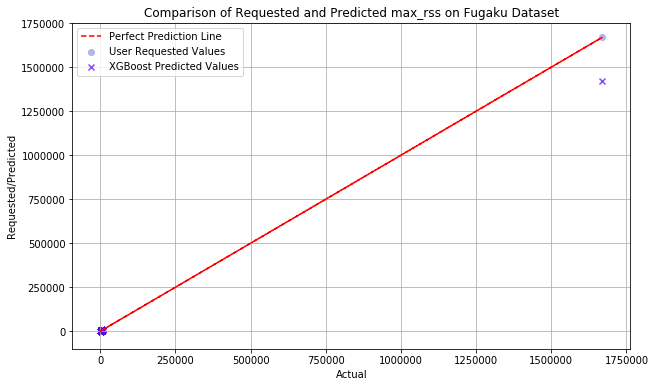

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


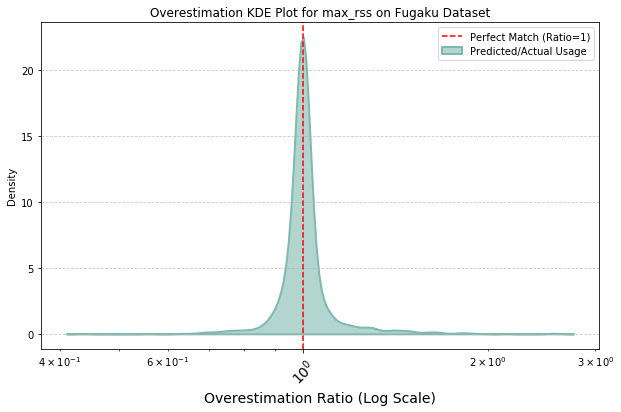

Processing cluster 17/20
Train size (X_train): 51016
Test size (X_test): 12755
Train size (y_train): 51016
Test size (y_test): 12755


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


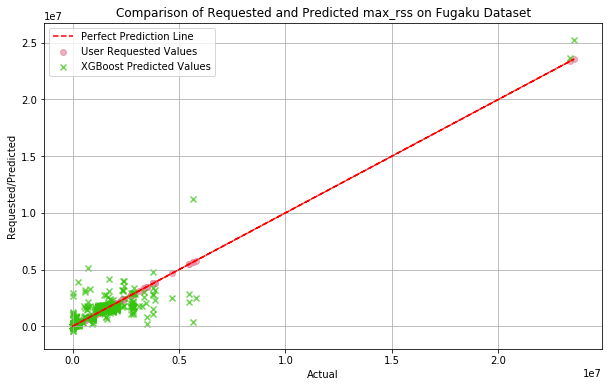

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


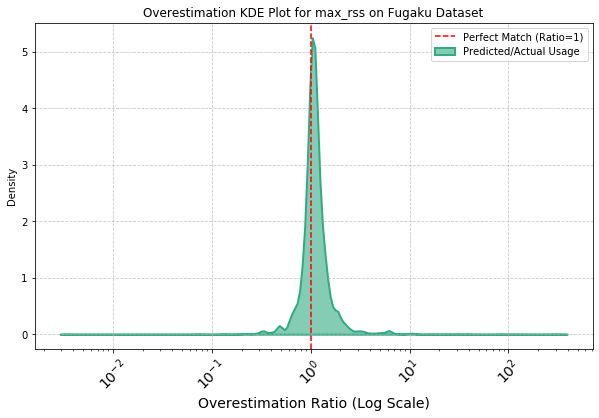

Processing cluster 18/20
Train size (X_train): 7055
Test size (X_test): 1764
Train size (y_train): 7055
Test size (y_test): 1764


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


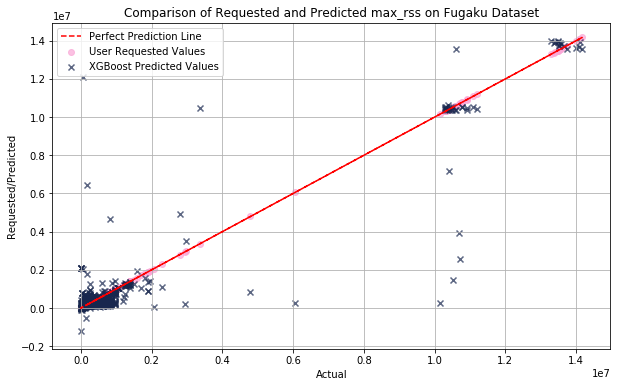

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


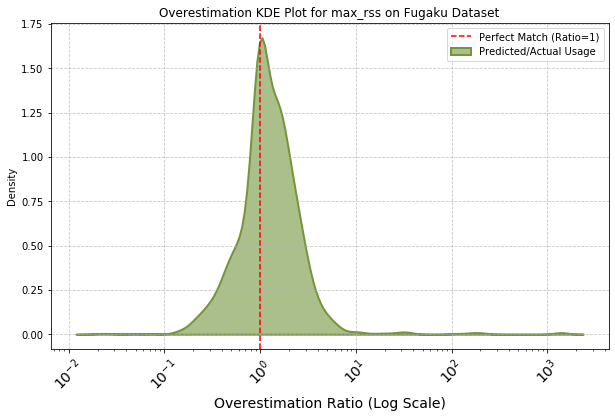

Processing cluster 19/20
Train size (X_train): 45185
Test size (X_test): 11297
Train size (y_train): 45185
Test size (y_test): 11297


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


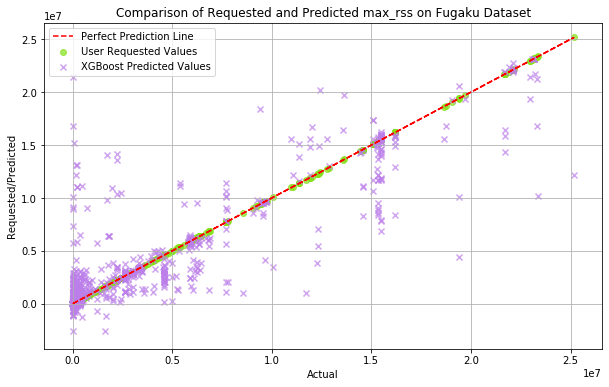

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


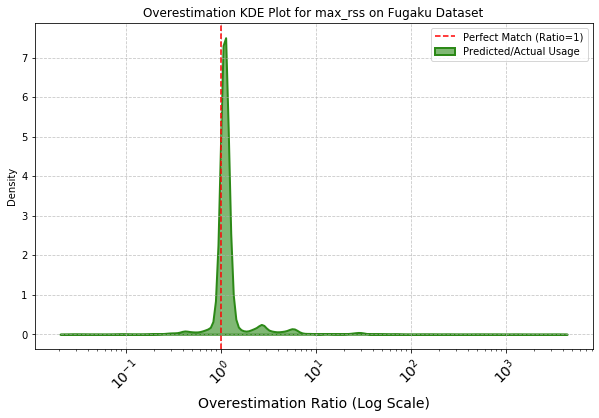

Processing cluster 20/20
Train size (X_train): 18360
Test size (X_test): 4590
Train size (y_train): 18360
Test size (y_test): 4590


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


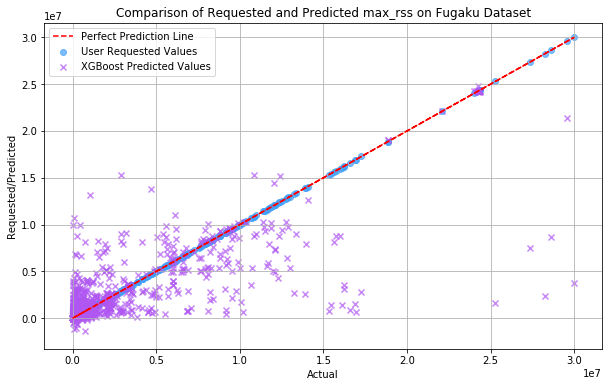

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


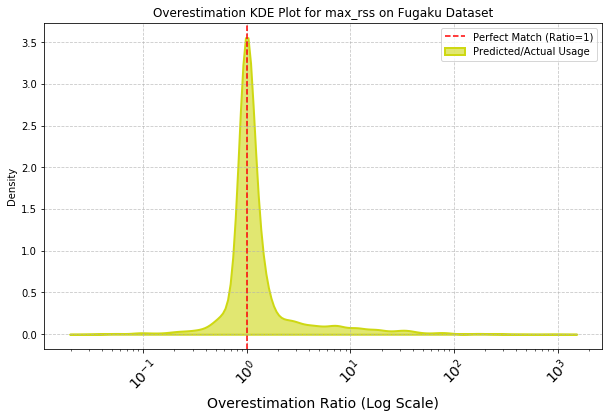

Average RMSE for Clustering: 624047.8537
Average MAE for Clustering: 161310.3057
Average R^2 for Clustering: 0.7771


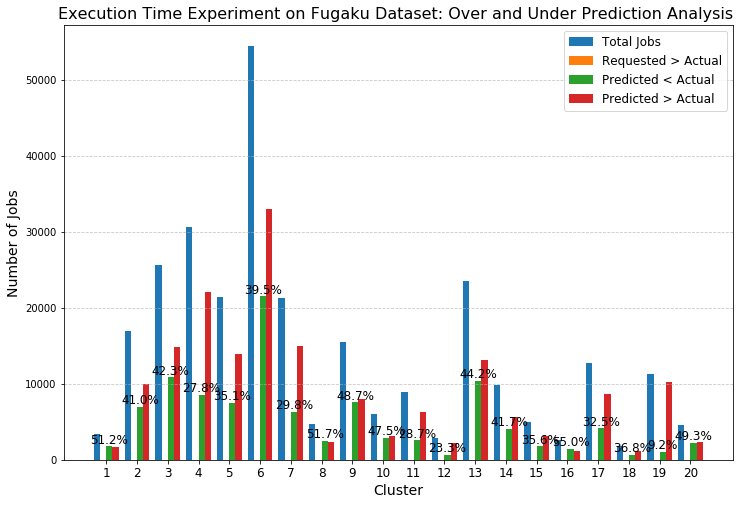

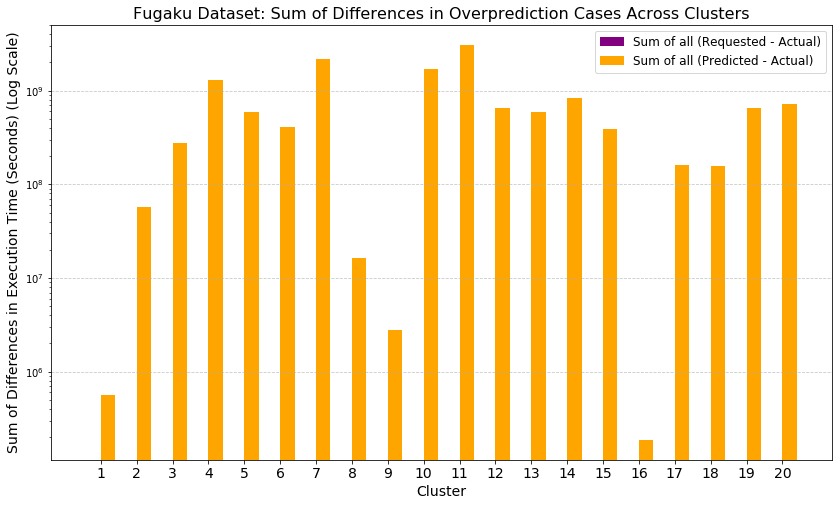

In [19]:
# Clustering
sub_dfs = cluster_create_sub_dataframes(df_success, train_features , ['max_rss'], 20)

rmse_list = []
mae_list = []
r2_list = []

metrics_data = []
overprediction_sums = []

for i, sub_df in enumerate(sub_dfs):
    print(f"Processing cluster {i+1}/{len(sub_dfs)}")
    
    rmse, mae, r2, y_test, y_pred, req_test= train_xgboost(sub_df, 'Fugaku Dataset', 'max_rss', train_features, 'max_rss')
    
    if rmse is not None:
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

        total_jobs = len(y_test)
        requested_gt_target = (req_test > y_test).sum()
        predicted_lt_actual = (y_pred < y_test).sum()
        predicted_gt_actual = (y_pred > y_test).sum()

        op1 = y_pred > y_test
        op2 = req_test > y_test
        
        sum_predicted_minus_actual = (y_pred[op1] - y_test[op1]).sum()
        sum_requested_minus_actual = (req_test[op2] - y_test[op2]).sum()

        metrics_data.append([i + 1, total_jobs, requested_gt_target, predicted_lt_actual, predicted_gt_actual])
        overprediction_sums.append([sum_predicted_minus_actual, sum_requested_minus_actual])

        


rmse = np.mean(rmse_list)
print(f"Average RMSE for Clustering: {rmse:.4f}")
mae = np.mean(mae_list)
print(f"Average MAE for Clustering: {mae:.4f}")
r2 = np.mean(r2_list)
print(f"Average R^2 for Clustering: {r2:.4f}")


plot_everything(metrics_data, overprediction_sums, 
                'Execution Time Experiment on Fugaku Dataset: Over and Under Prediction Analysis ', 
                'Fugaku Dataset: Sum of Differences in Overprediction Cases Across Clusters',
                'Execution Time (Seconds)')



Train size (X_train): 1132741
Test size (X_test): 283186
Train size (y_train): 1132741
Test size (y_test): 283186


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarn

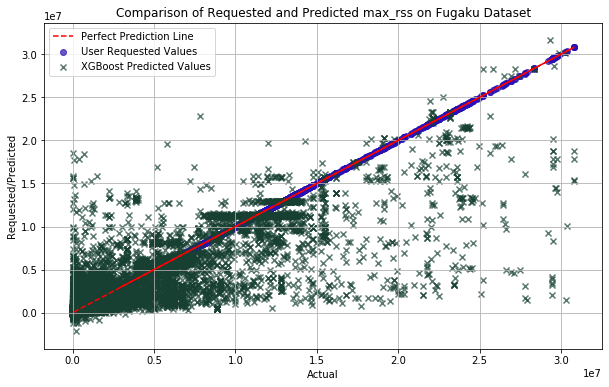

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


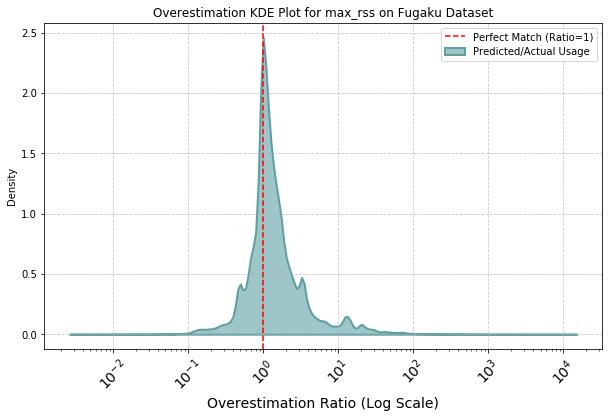

RMSE: 673879.1534
MAE: 150319.7095
R^2: 0.8370


In [18]:
# No feature selection

train_features = ['user_id', 'command', 'gpu_mode']
rmse, mae, r2, y_test, y_pred, req_test = train_xgboost(df_success, 'Fugaku Dataset', 'max_rss', train_features , 'max_rss')

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")


# Old Functions

In [ ]:
row_counts = df.groupby('user_id').size()
users_with_enough_data = row_counts[row_counts >= 10].index
filtered_df = df[df['user_id'].isin(users_with_enough_data)]

# Get the top 10 users by job count
top_10_users = filtered_df.groupby('user_id').size().sort_values(ascending=False).head(10)

# Convert the result to a DataFrame for a cleaner display
top_10_users_df = top_10_users.reset_index(name='job_count')

# Display the group names along with their job counts
print(top_10_users_df)

In [ ]:
# --- Helper Functions ----

def custom_loss(alpha, beta):
    def loss(y_true, y_pred):
        error = y_true - y_pred
        squared_error = tf.square(error)
        
        weighted_error = tf.where(error > 0, alpha * squared_error, beta * squared_error)
        return tf.reduce_mean(weighted_error)
    return loss

def dtw_distance(s1, s2):
    """Calculate Dynamic Time Warping (DTW) distance between two time series."""
    n, m = len(s1), len(s2)
    dtw = np.zeros((n + 1, m + 1))
    
    for i in range(n + 1):
        for j in range(m + 1):
            dtw[i, j] = float('inf')
    
    dtw[0, 0] = 0
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(s1[i - 1] - s2[j - 1])
            dtw[i, j] = cost + min(dtw[i - 1, j],    # Insertion
                                   dtw[i, j - 1],    # Deletion
                                   dtw[i - 1, j - 1])  # Match
    
    return dtw[n, m]

def dtw_metric(y_true, y_pred):
    """Calculate Dynamic Time Warping (DTW) score between true and predicted values."""
    return dtw_distance(y_true, y_pred)

def mean_absolute_error(y_true, y_pred):
    """Calculate Mean Absolute Error (MAE) between true and predicted values."""
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE) between true and predicted values."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test).flatten()
    
    dtw_score = dtw_metric(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    return {
        'DTW': dtw_score,
        'MAE': mae,
        'MAPE': mape
    }

In [ ]:
# ---- Data Preprocessing for ML -----

def preprocess_data(group_data, lag=3):
    lag_features = []
    for i in range(1, lag + 1):
        group_data[f'max_rss_{i}'] = group_data['max_rss'].shift(i)
        lag_features.append(f'max_rss_{i}')

    # Drop rows with NaN resulting from the lag
    group_data.dropna(inplace=True)


    X = group_data[lag_features].values
    y = group_data['max_rss'].values

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]


    # Reshape data
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    X_train = np.array(X_train, dtype=np.float32)
    X_test = np.array(X_test, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)

    return X_train, X_test, y_train, y_test


In [ ]:
# ---- Creating Machine Learning Models -----

# --- LSTM ----

def build_lstm_model(input_shape, alpha, beta):
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='relu')
    ])
    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=custom_loss(alpha, beta),
                  metrics=['mean_squared_error'])
    return lstm_model

# --- BNN ----

def build_bnn_model(input_shape, alpha, beta):
    bnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation='relu')
    ])
    bnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=custom_loss(alpha, beta),
                  metrics=['mean_squared_error'])
    return bnn_model


# --- CNN ----

def build_cnn_model(input_shape, alpha, beta):
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation='relu')
    ])
    cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=custom_loss(alpha, beta),
                      metrics=['mean_squared_error'])
    return cnn_model


In [ ]:
results = []

# Custom loss parameters
alpha = 1.0
beta = 1.0 

for owner in range(1,2): # Apply the ML models for all 10 groups
    print(f"Processing user: {owner}")
    group_data = df[df['user_id'] == 'User1004'].copy()
    
    X_train, X_test, y_train, y_test = preprocess_data(group_data, lag=3)
    input_shape = (X_train.shape[1], 1)
    bias = np.mean(y_train)


    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # LSTM Model
    lstm_model = build_lstm_model(input_shape, alpha, beta)
    lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                                 validation_split=0.2, callbacks=[early_stopping])
    lstm_y_pred_without_bias = lstm_model.predict(X_test).flatten()
    lstm_y_pred = lstm_y_pred_without_bias + bias
    mse_lstm = mean_squared_error(y_test, lstm_y_pred)
    
    # CNN Model
    cnn_model = build_cnn_model(input_shape, alpha, beta)
    cnn_history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                               validation_split=0.2, callbacks=[early_stopping])
    cnn_y_pred_without_bias = cnn_model.predict(X_test).flatten()
    cnn_y_pred = cnn_y_pred_without_bias + bias
    mse_cnn = mean_squared_error(y_test, cnn_y_pred)
    
    # BNN Model
    bnn_model = build_bnn_model(input_shape, alpha, beta)
    bnn_history = bnn_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                               validation_split=0.2, callbacks=[early_stopping])
    bnn_y_pred_without_bias = bnn_model.predict(X_test).flatten()
    bnn_y_pred = bnn_y_pred_without_bias + bias
    mse_bnn = mean_squared_error(y_test, bnn_y_pred)
    
    # Calculate some more informative metrics
    for y_pred, mse, model_name in zip([lstm_y_pred, cnn_y_pred, bnn_y_pred],
                                        [mse_lstm, mse_cnn, mse_bnn],
                                        ['LSTM', 'CNN', 'BNN']):

        # Append results
        results.append({
            'owner': owner,
            'model': model_name,
            'mse': mse
        })

    # Plot the results
    draw_combined_prediction_results(y_test, lstm_y_pred, cnn_y_pred, bnn_y_pred, owner)